In [1]:
import warnings
warnings.filterwarnings('ignore')
## import data
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv").set_index("Id")
test = pd.read_csv("test.csv").set_index("Id")
combine = pd.concat([train, test])

# process data before model fitting
from preprocessfinal import impute
fact, encodedDic = impute(combine, False)  # process data and label encode 

# seperate factorized data into train and test
train_label = fact.iloc[0:1460,]
test_label = fact.iloc[1460:2919,].drop('SalePrice', axis = 1) # salesprice col were all NA 

# split train data frame into x var and y var for model testing
x_label = train_label.drop('SalePrice', axis=1)
y_log = np.log(train_label.SalePrice)

In [3]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

randomForest = ensemble.RandomForestRegressor()
grid_para_forest = [{
    "n_estimators": np.arange(100, 400, 100),
    "min_samples_leaf": range(10,15),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [42]}]
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_forest.fit(x_label, y_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': array([100, 200, 300]), 'min_samples_leaf': range(10, 15), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [4]:
print("Best parameters found: ", grid_search_forest.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search_forest.best_score_)))

Best parameters found:  {'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
Lowest RMSE found:  0.1503675297419843


#### RMSE for all train data using best random forest

In [5]:
# fit best random forest to all train data 
best_forest_y = grid_search_forest.best_estimator_.predict(x_label)
print("RMSE: ", np.sqrt(np.mean(y_log-best_forest_y)**2))

RMSE:  0.00018805264791066581


#### Feature importance

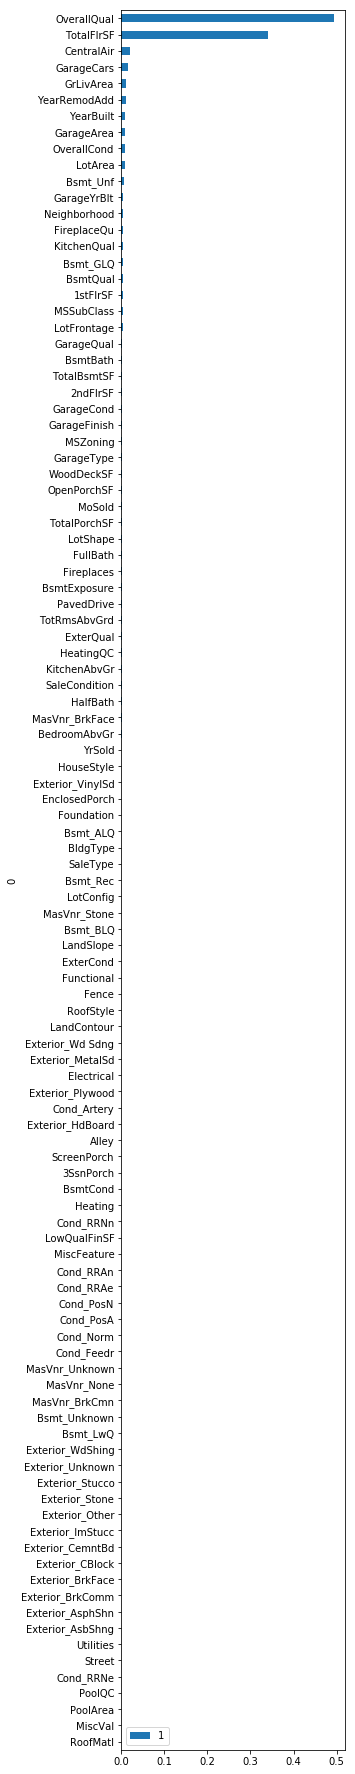

In [14]:
import matplotlib.pyplot as plt
pd.DataFrame(list(zip(x_label.columns, grid_search_forest.best_estimator_.feature_importances_ ))).set_index(0).sort_values(1).plot.barh()
plt.rcParams['figure.figsize'] = 4, 32

#### test prediction

In [7]:
best_forest_test_y = grid_search_forest.best_estimator_.predict(test_label) 
best_forest_test_y = np.expm1(best_forest_test_y)
sub = pd.DataFrame() 
sub['SalePrice'] = best_forest_test_y
sub = sub.set_index(np.arange(1461, 2920))
sub.to_csv('(4) forest_log(y)_label_submission.csv')

# Extreme Gradient Boosting Random Forest (regression)

In [8]:
# !pip install xgboost

In [9]:
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgbforest = xgb.XGBRegressor()
grid_para_xgbforest = [{
    "colsample_bytree": np.linspace(0.1, 0.9, 9),
    'max_depth':[2, 4, 6],
    "n_estimators": np.arange(500, 1000, 100),
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "random_state": [42]}]
grid_search_xgbforest = GridSearchCV(estimator = xgbforest, param_grid = grid_para_xgbforest, 
                                     scoring = 'neg_mean_squared_error', cv = 5, n_jobs=-1)

grid_search_xgbforest.fit(x_label, y_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'max_depth': [2, 4, 6], 'n_estimators': array([500, 600, 700, 800, 900]), 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [10]:
print("Best parameters found: ", grid_search_xgbforest.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search_xgbforest.best_score_)))

Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 42}
Lowest RMSE found:  0.11953516580561195


#### RMSE for all train data using best gradient boost

In [11]:
# fit best XGB to all train data 
best_xgbforest_y = grid_search_xgbforest.best_estimator_.predict(x_label)
print("RMSE: ", np.sqrt(np.mean(y_log-best_xgbforest_y)**2))

RMSE:  7.743956133943185e-06


#### Feature importance

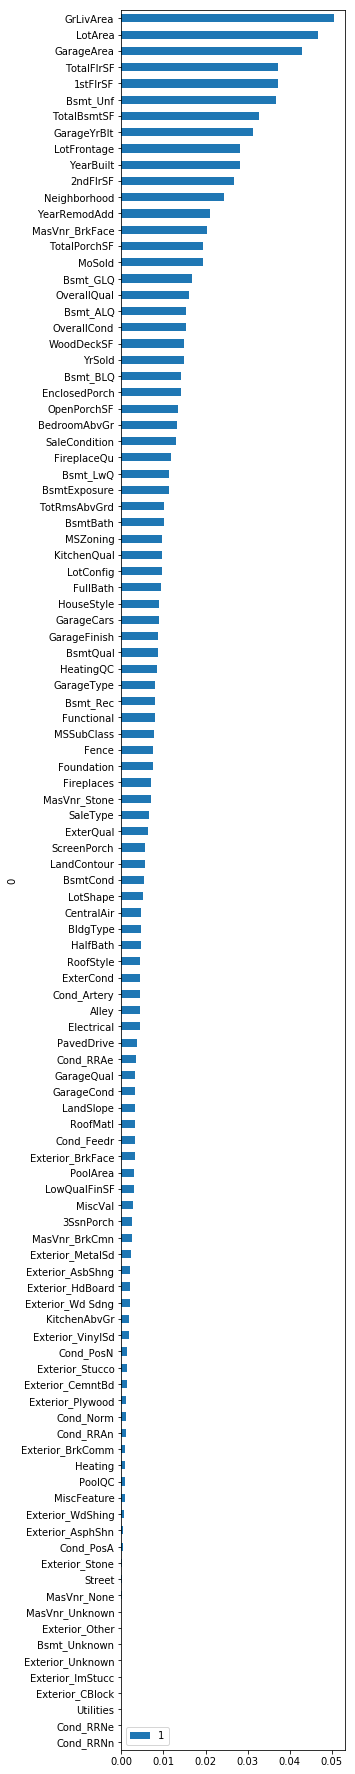

In [15]:
import matplotlib.pyplot as plt
pd.DataFrame(list(zip(x_label.columns, grid_search_xgbforest.best_estimator_.feature_importances_ ))).set_index(0).sort_values(1).plot.barh()
plt.rcParams['figure.figsize'] = 4, 32

#### test prediction

In [13]:
best_xgb_test_y = grid_search_xgbforest.best_estimator_.predict(test_label) 
best_xgb_test_y = np.expm1(best_xgb_test_y)
sub = pd.DataFrame() 
sub['SalePrice'] = best_xgb_test_y
sub = sub.set_index(np.arange(1461, 2920))
sub.to_csv('(5) xgb_log(y)_label_submission.csv')